## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection as skl
from skimage import io, exposure
from random import sample 
from scipy.ndimage import gaussian_filter
from skimage.util import random_noise

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import binarize

from keras import backend as K
from skimage.transform import resize

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.applications.imagenet_utils import decode_predictions

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6880,00001836_066.png,No Finding,66,1836,50,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00001836_066.png
104871,00028122_002.png,No Finding,2,28122,44,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00028122_002.png
55671,00013924_004.png,No Finding,4,13924,59,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00013924_004.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39288,00010298_003.png,Infiltration,3,10298,74,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50017,00012659_001.png,No Finding,1,12659,58,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51575,00013031_010.png,Emphysema|Infiltration,10,13031,54,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df["pneumonia_class"] = np.where(all_xray_df["Pneumonia"] == 1, "pneumonia", "no")
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no


## Create your training and testing data:

In [5]:
def create_splits(dataframe, test_size, stratify):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(dataframe,
                                                test_size = test_size, 
                                                stratify = dataframe[stratify])
    
    return train_data, val_data

train_data, val_data = create_splits(all_xray_df, 0.2, "Pneumonia")

In [6]:
# Before, the train and validation datasets were stratified according to pneumonia cases
# However, the training set have to include the same number of positive and negative cases

p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [7]:
pv_inds = val_data[val_data.Pneumonia==1].index.tolist()
npv_inds = val_data[val_data.Pneumonia==0].index.tolist()

npv_sample = sample(npv_inds,np.round(len(pv_inds)/3).astype(int))
val_data = val_data.loc[pv_inds + npv_sample]

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
# Other than the built in augmentation options, three additional modifications were included:
# 1. Blurring: applying a gaussian filter
# 2. Equalization: applying histogram equalization
# 3. Noise: adding random noise
# Code based on the publication at: https://www.kaggle.com/fraluc/cnn-keras-with-custom-data-augmentation-99-52

class CustomAugmentation(object):
    
    def __init__(self, blurring = False, equalization = False, noise = False):
        self.blurring = blurring
        self.equalization = equalization
        self.noise = noise
    
    def __call__(self, img):
        
        randomNumber = np.random.random()
        
        # Apply to 5% of images each modification in case is True
        
        if randomNumber < 0.85:
            pass
        elif randomNumber < 0.9:
            if self.blurring == True:
                # Apply blurring 5% of the time if True
                img = gaussian_filter(img, sigma=2)
        elif randomNumber < 0.95:
            if self.equalization == True:
                # Apply equalization 5% of the time if True
                img = exposure.equalize_adapthist(img/255)*255
        else:
            if self.noise == True:
                # Apply noise 5% of the time if True
                img = random_noise(img/255)*255
                
        return img


preprocessor = CustomAugmentation(blurring = True, equalization = True, noise = True)

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = True, 
                                vertical_flip = False, 
                                height_shift_range= 0.1, 
                                width_shift_range=0.1, 
                                rotation_range=15,
                                shear_range = 0.1,
                                zoom_range=0.1,
                                preprocessing_function = preprocessor) 
    
    return my_idg


def make_train_gen(dataframe, idg, IMG_SIZE):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = idg.flow_from_dataframe(dataframe= dataframe, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = IMG_SIZE,
                                        batch_size = 128
                                 )

    
    return train_gen


def make_val_gen(dataframe, IMG_SIZE):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

    val_gen = val_idg.flow_from_dataframe(dataframe=dataframe, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 128
                                         )
    
    return val_gen

In [9]:
my_idg = my_image_augmentation()
train_gen = make_train_gen(train_data, my_idg, (224, 224))
val_gen = make_val_gen(val_data, (224, 224))

Found 2290 validated image filenames belonging to 2 classes.
Found 381 validated image filenames belonging to 2 classes.


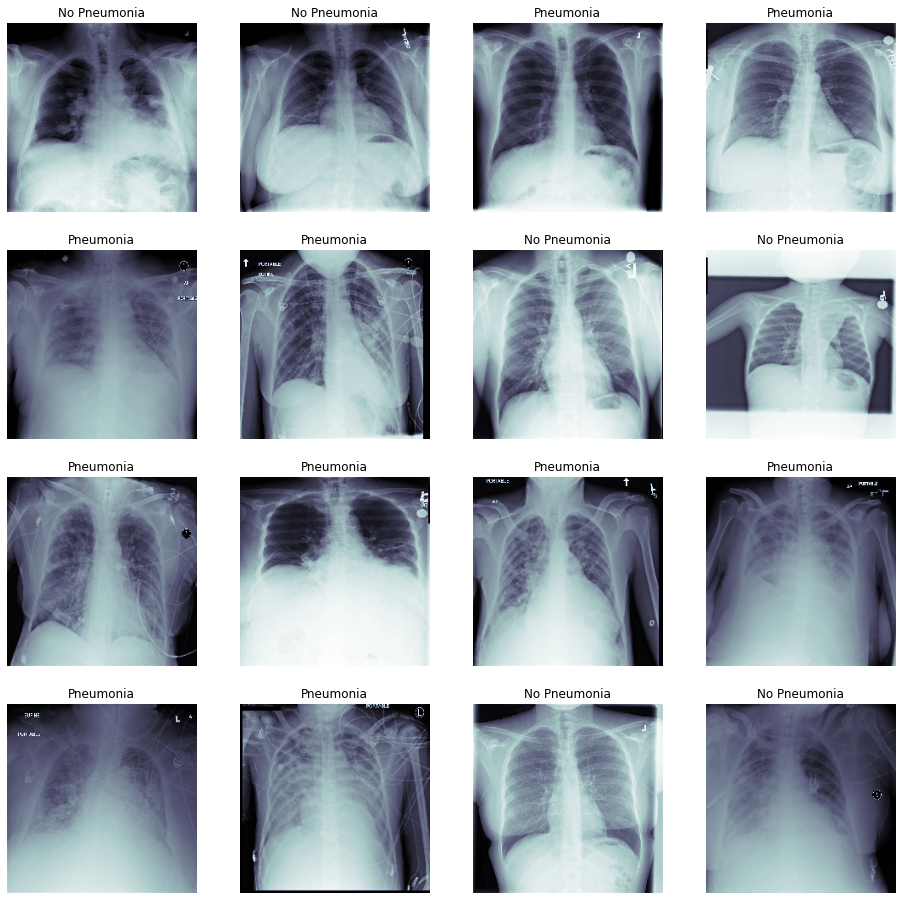

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(valX, valY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

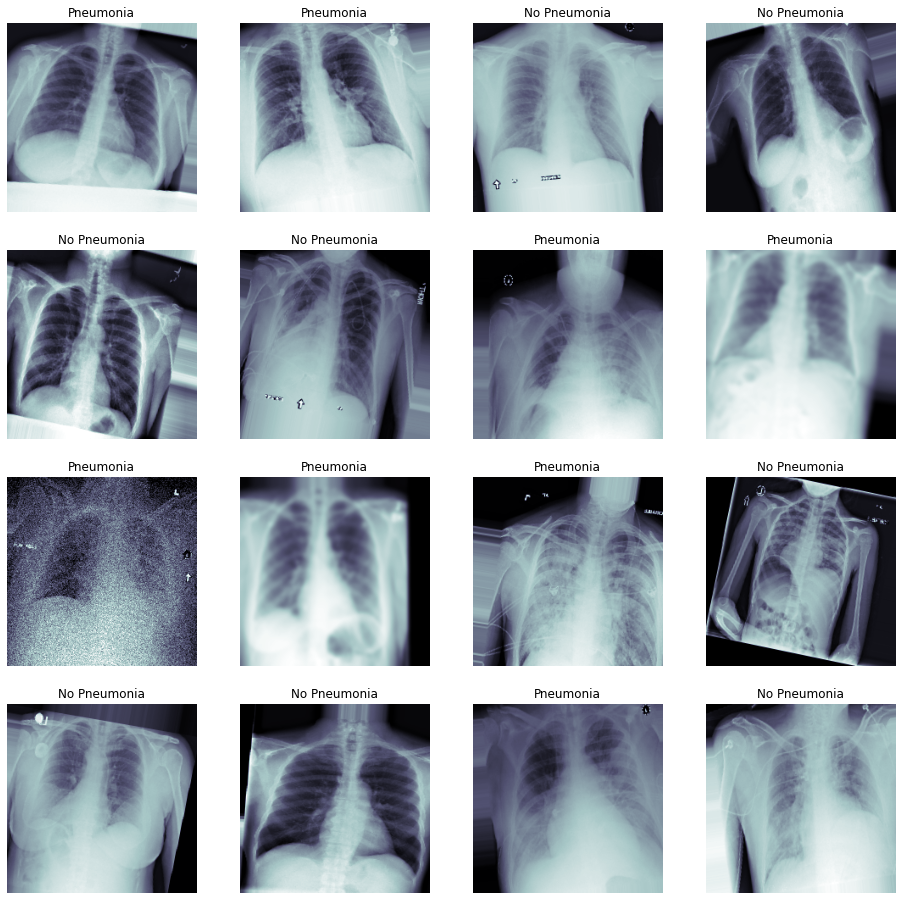

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    model = Model(inputs=model.input,
                      outputs=transfer_layer.output)

    for layer in model.layers[0:17]:
        layer.trainable = False
    
    for layer in model.layers:
        print(layer.name, layer.trainable)
    
    return model

In [13]:
def build_my_model(model):
    
    new_model = Sequential()
    
    new_model.add(model)
    
    new_model.add(Flatten())
    
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))
    
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.3))
    
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dropout(0.3))
    
    new_model.add(Dense(64, activation='relu'))
    new_model.add(Dropout(0.2))
    
    new_model.add(Dense(32, activation='relu'))
    new_model.add(Dropout(0.2))
    
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-6)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= "val_loss", 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "min", 
                              save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                       mode= "min", 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________


Epoch 00017: val_loss improved from 0.65846 to 0.65754, saving model to xray_class_my_model.best.hdf5
Epoch 18/30
18/18 [==============================] - 66s 4s/step - loss: 0.7632 - binary_accuracy: 0.4891 - val_loss: 0.6571 - val_binary_accuracy: 0.6875

Epoch 00018: val_loss improved from 0.65754 to 0.65714, saving model to xray_class_my_model.best.hdf5
Epoch 19/30
18/18 [==============================] - 66s 4s/step - loss: 0.7438 - binary_accuracy: 0.5092 - val_loss: 0.6567 - val_binary_accuracy: 0.6875

Epoch 00019: val_loss improved from 0.65714 to 0.65667, saving model to xray_class_my_model.best.hdf5
Epoch 20/30
18/18 [==============================] - 66s 4s/step - loss: 0.7415 - binary_accuracy: 0.5013 - val_loss: 0.6561 - val_binary_accuracy: 0.6875

Epoch 00020: val_loss improved from 0.65667 to 0.65609, saving model to xray_class_my_model.best.hdf5
Epoch 21/30
18/18 [==============================] - 66s 4s/step - loss: 0.7382 - binary_accuracy: 0.4996 - val_loss: 0.656

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 128, verbose = True)

128/128 [==============================] - 1s 10ms/step


In [17]:
def plot_roc_curve(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return fpr, tpr, thresholds

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
    return precision, recall, thresholds

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1_threshold(valY, pred_Y, threshold):
    
    f1_scores = []
    for i in threshold:
        f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
        f1_scores.append(f1)
        f1_max = np.max(f1_scores)
        f1_max_ind = np.argmax(f1_scores)
        
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(threshold, f1_scores)
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Score')

    return f1_max, f1_max_ind
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

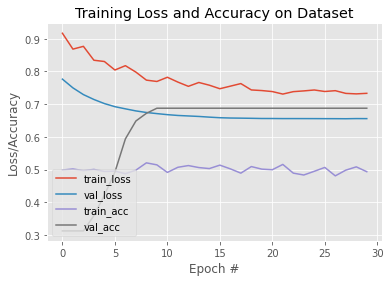

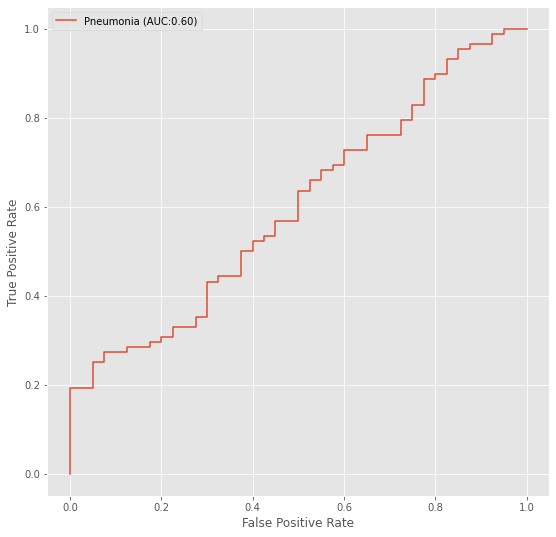

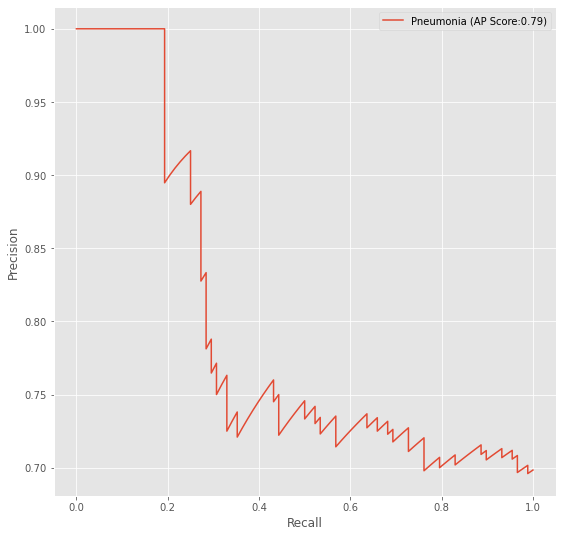

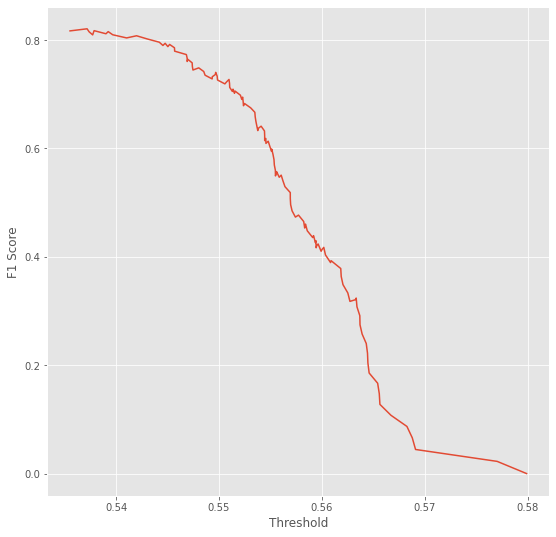

In [18]:
## plot figures

plot_history(history)
fpr, tpr, thres_roc = plot_roc_curve(valY, pred_Y)
precision, recall, thres_PR = plot_precision_recall_curve(valY, pred_Y)
f1_max, f1_max_ind = plot_f1_threshold(valY, pred_Y, thres_PR);

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Look at the threshold with precision
precision_value = thres_PR[f1_max_ind]
idx = (np.abs(precision - precision_value)).argmin()
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thres_PR[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.696
Recall is: 0.9886363636363636
Threshold is: 0.5371808
F1 Score is: 0.8169014084507042


In [20]:
# Look at the threshold with recall
recall_value = thres_PR[f1_max_ind]
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thres_PR[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.7230769230769231
Recall is: 0.5340909090909091
Threshold is: 0.5545483
F1 Score is: 0.6143790849673202


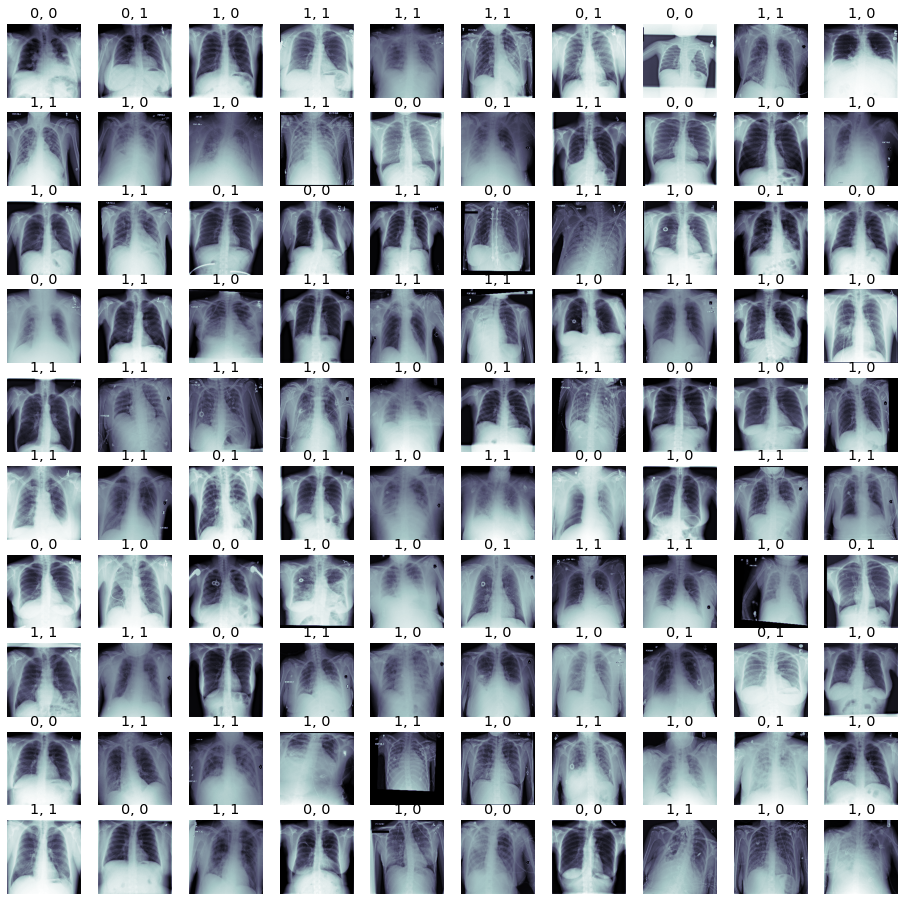

In [21]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thres_PR[idx]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thres_PR[idx]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [22]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Conclusions:
# 1. Thanks to the suggestions made by the reviewer, it was possible to select an adequate validation dataset, improving the 
# the performance and the general evaluation meytrics, including the F1 score. The selected F1 score was 0.81, above the value
# reported in literature of 0.35-0.4
# 2. Several parameters were modified and mixed in the search for a good model: transfer model (VGG16 and resnet), optimizer
# (Adam and SGD), learning rate, final layers, among others.
# 3. The amount of data and the dataset characteristics affects the training and final results of the process, making evident
# the importance of the data to obtain an optimal result.